## Transit Travel time & distance
Using the Google maps API

In [1]:
import googlemaps
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
import pickle

In [2]:
# Load data
mrdh = pd.read_pickle("../v_mrdh/areas_mrdh.pkl")
print("Source CRS:", mrdh.crs)
mrdh.head()

Source CRS: EPSG:28992


,geometry,65x65 Naam,GEBIEDEN,WONINGEN_A,INWONERS_A,ARBEIDSPL_,LLP12EO_AR,LLP0011_AR,PARKEER_TA,AUTOSPERHH,...,1: woningen,2: inwoners,3: inwon0034,4: bbv,5: llp12eo,6: detail,7: industrie,8: rest,9: arbeidspl_totaal,10: gebiedstype
65x65 Nummer,,,,,,,,,,,,,,,,,,,,,
1,"MULTIPOLYGON (((91572.39 435285.08, 91571.6 43...",Rotterdam Centrum,studiegebied RVMK,21529,36209,88158,37649,2213,4.14,0.495,...,21529,36209,18948,16284,37649,9151,7019,71988,88158,1
2,"POLYGON ((89429 435269.999, 89384 435277.999, ...",Delfshaven,studiegebied RVMK,39740,77508,17468,9165,6332,1.76,0.460,...,39740,77508,41160,30429,9165,3430,1068,12970,17468,1
3,"POLYGON ((89677.053 437491.512, 89672.17 43749...",Noord,studiegebied RVMK,29516,52490,12453,10649,2807,1.76,0.425,...,29516,52490,27808,23956,10649,3235,499,8719,12453,1
4,"POLYGON ((93801.859 437558.61, 93800.797 43756...",Kralingen,studiegebied RVMK,30714,53939,25025,36520,4257,1.76,0.480,...,30714,53939,28785,19379,36520,2758,4634,17633,25025,1
5,"POLYGON ((94944.584 431561.346, 94944.374 4315...",IJsselmonde (bi),studiegebied RVMK,22324,45467,16658,4404,3906,0.00,0.650,...,22324,45467,19990,16927,4404,2587,1931,12140,16658,1


In [3]:
# Load NS stations
ns_stations = pd.read_pickle("../travel_api/urban_stations.pkl")
print("Source CRS:", ns_stations.crs)
ns_stations.head()

Source CRS: EPSG:28992


,id,stationType,names,location,tracks,hasKnownFacilities,availableForAccessibleTravel,hasTravelAssistance,areTracksIndependentlyAccessible,isBorderStop,...,1: woningen,2: inwoners,3: inwon0034,4: bbv,5: llp12eo,6: detail,7: industrie,8: rest,9: arbeidspl_totaal,10: gebiedstype
31,"{'uicCode': '8400090', 'evaCode': '8400090', '...",LOCAL_TRAIN_STATION,"{'long': 'Barendrecht', 'medium': 'Barendrcht'...","{'lat': 51.8547210693359, 'lng': 4.5533332824707}","[1, 2, 3, 4]",True,True,True,False,False,...,19278,48738,19426,22221,5376,6030,5169,13908,25107,1
56,"{'uicCode': '8400135', 'evaCode': '8400135', '...",LOCAL_TRAIN_STATION,"{'long': 'Lansingerland-Zoetermeer', 'medium':...","{'lat': 52.042222, 'lng': 4.517222}","[1, 2]",True,True,True,True,False,...,55903,125080,50951,54981,8388,9663,6454,29994,46111,1
62,"{'uicCode': '8400147', 'evaCode': '8400147', '...",LOCAL_TRAIN_STATION,"{'long': 'Capelle Schollevaar', 'medium': 'Sch...","{'lat': 51.9541664123535, 'lng': 4.58416652679...","[1, 2]",True,True,True,False,False,...,31330,66977,26700,28611,3066,5308,4688,24613,34609,1
72,"{'uicCode': '8400166', 'evaCode': '8400166', '...",LOCAL_TRAIN_STATION,"{'long': 'Delft Campus', 'medium': 'Delft Camp...","{'lat': 51.9908332824707, 'lng': 4.36472225189...","[1, 2]",True,True,True,True,False,...,58802,103319,52411,38937,39021,6907,5996,37415,50318,1
76,"{'uicCode': '8400170', 'evaCode': '8400170', '...",INTERCITY_HUB_STATION,"{'long': 'Delft', 'medium': 'Delft', 'short': ...","{'lat': 52.0066680908203, 'lng': 4.35638904571...","[1, 2]",True,True,True,True,False,...,58802,103319,52411,38937,39021,6907,5996,37415,50318,1


In [4]:
# Coordinates for the polygon
coordinates = [
    (4.4990746, 51.9762347),
    (4.4782925, 51.9761290),
    (4.4496103, 51.9699249),
    (4.4198962, 51.9593188),
    (4.3244782, 51.9397037),
    (4.3090174, 51.9189005),
    (4.3074716, 51.8962450),
    (4.3203072, 51.8937360),
    (4.3354215, 51.8630147),
    (4.3500308, 51.8505497),
    (4.3707192, 51.8439906),
    (4.3919387, 51.8418568),
    (4.4114458, 51.8430026),
    (4.4589756, 51.8308224),
    (4.4948745, 51.8359273),
    (4.5239904, 51.8294898),
    (4.5493683, 51.8313068),
    (4.5780828, 51.8237958),
    (4.6195911, 51.8511542),
    (4.6459819, 51.8642957),
    (4.6339985, 51.8706785),
    (4.6194791, 51.8886225),
    (4.6422223, 51.8910727),
    (4.6477144, 51.9153997),
    (4.6208137, 51.9346689),
    (4.6365819, 51.9735894),
    (4.5975938, 51.9967341),
    (4.5212392, 51.9771122),
    (4.5005548, 51.9760425),
    (4.4990746, 51.9762347)
]

# Creating a Polygon object
city_polygon = Polygon(coordinates)

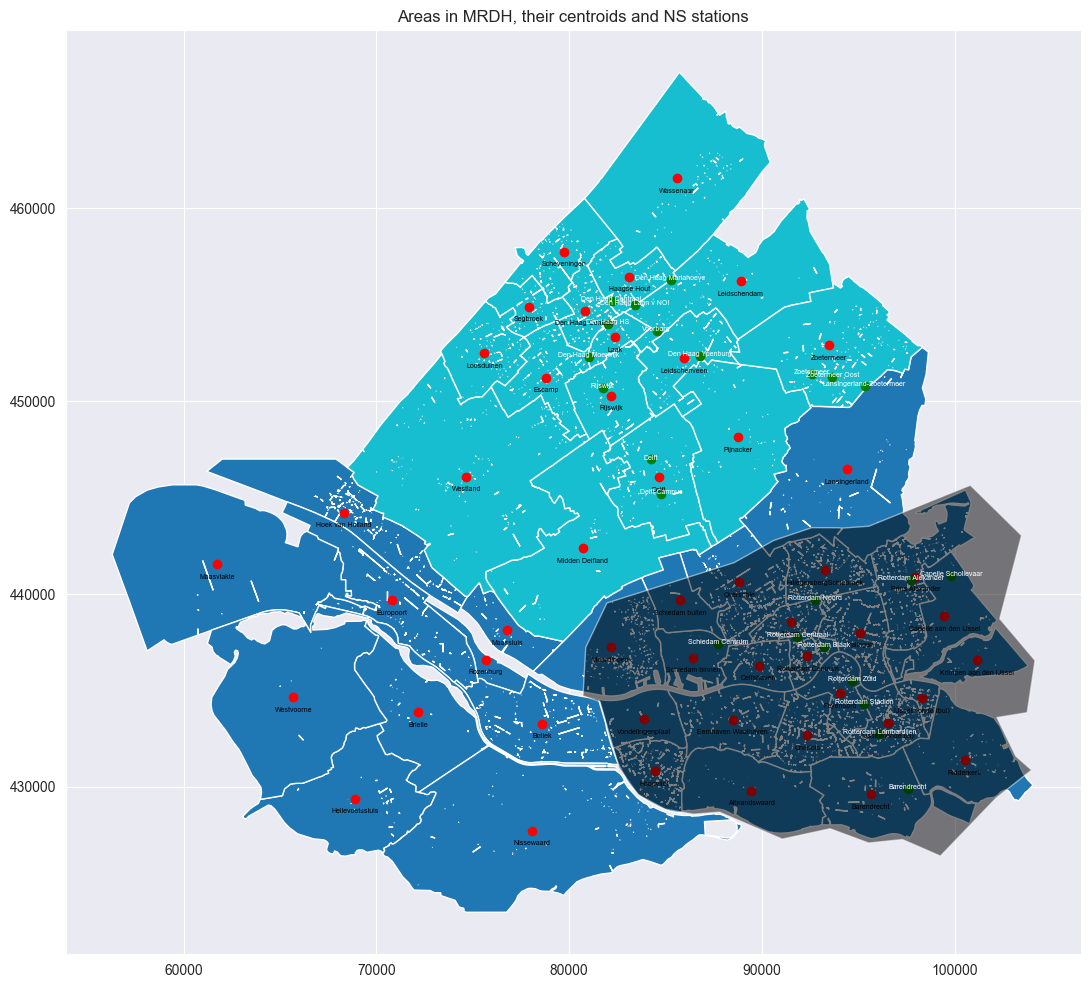

In [5]:
fig, ax = plt.subplots(figsize=(16, 12))
# Filter data to only include postcodes in the Randstad
mrdh.plot(column="GEBIEDEN", figsize=(16, 12), ax=ax)
# Add the centroids
mrdh.centroid.plot(ax=ax, color="red")
# Add the name labels above the centroids
for x, y, label in zip(mrdh.centroid.x, mrdh.centroid.y-750, mrdh["65x65 Naam"]):
    ax.text(x, y, label, color="black", fontsize=5, ha="center")
    
# Add the NS stations
ns_stations.plot(ax=ax, color="green")
# Add the name labels above the NS stations
for x, y, label in zip(ns_stations.geometry.x, ns_stations.geometry.y, ns_stations["name"]):
    ax.text(x, y, label, color="white", fontsize=5, ha="center")

# Add the city polygon (CRS 3857)
city_polygon_series = gpd.GeoSeries(city_polygon, crs="epsg:4326")
# Convert to epsg:28992
city_polygon_series = city_polygon_series.to_crs(epsg=28992)
city_polygon_series.plot(ax=ax, color="black", alpha=0.5)
# Add a title
plt.title("Areas in MRDH, their centroids and NS stations")
# Save the plot
plt.savefig("areas_mrdh_ns_stations.png", dpi=300, bbox_inches="tight")

### Get weighted centroids

In [6]:
# Load areas_65.pkl
areas_65 = pd.read_pickle("../v_mrdh/areas_65.pkl")

In [7]:
# Load the population data
population = pd.read_pickle("../data/population_data_pc4.pkl")
# Remove 0 inhabitants
population = population[population['aantal_inwoners'] > 0]

In [8]:
# Perform the spatial join with the 'touches' predicate
pop_mrdh = gpd.sjoin(population, areas_65, how='inner', predicate='intersects')

# Calculate the intersection areas
pop_mrdh['intersection_area'] = pop_mrdh.apply(
    lambda row: row.geometry.intersection(areas_65.loc[row['65x65 Nummer']].geometry).area, axis=1
)

# Sort the result by intersection area in descending order and drop duplicates, keeping the largest
pop_mrdh = pop_mrdh.sort_values(by='intersection_area', ascending=False)
# Drop duplicates, keeping one row per postcode
pop_mrdh = pop_mrdh.drop_duplicates(subset='postcode', keep='first')

# Drop any columns with a 65x65 Nummer that not in the mrdh index
pop_mrdh = pop_mrdh[pop_mrdh['65x65 Nummer'].isin(mrdh.index)]

In [9]:
# Stupid fix for an extra polygon in the multipolygon geometry in postcode 3053 and 2641
from shapely.geometry import MultiPolygon

pop_mrdh.loc[pop_mrdh["postcode"] == 3053, 'geometry'] = pop_mrdh.loc[pop_mrdh["postcode"] == 3053, 'geometry'].apply(lambda geom: MultiPolygon(list(geom.geoms)[:-1]) if isinstance(geom, MultiPolygon) else geom)
pop_mrdh.loc[pop_mrdh["postcode"] == 2641, 'geometry'] = pop_mrdh.loc[pop_mrdh["postcode"] == 2641, 'geometry'].apply(lambda geom: MultiPolygon(list(geom.geoms)[:-1]) if isinstance(geom, MultiPolygon) else geom)

In [10]:
# Remove areas with 0 INWONERS_A
pop_mrdh = pop_mrdh[pop_mrdh['INWONERS_A'] > 0]
mrdh = mrdh[mrdh['INWONERS_A'] > 0]

# Remove areas from mrdh with no population
# mrdh = mrdh[mrdh.index.isin(pop_mrdh['65x65 Nummer'])]

In [11]:
from shapely.geometry import Point

# Step 1: Group by 65x65 Nummer
grouped = pop_mrdh.groupby('65x65 Nummer')

# Step 2: Calculate weighted centroids
def weighted_centroid(group):
    total_population = group['aantal_inwoners'].sum()
    wx = (group.geometry.centroid.x * group['aantal_inwoners']).sum() / total_population
    wy = (group.geometry.centroid.y * group['aantal_inwoners']).sum() / total_population
    return pd.Series({'geometry': Point(wx, wy), 'total_population': total_population})

weighted_centroids = grouped.apply(weighted_centroid).reset_index()

# Step 3: Create a new geodataframe with the results. Set the 65x65 Nummer as the index
result_gdf = gpd.GeoDataFrame(weighted_centroids, geometry='geometry')
result_gdf.set_index('65x65 Nummer', inplace=True)

# Step 4: Add the weighted centroids to the mrdh geodataframe
mrdh['weighted_centroid'] = result_gdf['geometry']

C:\Users\Ewout\AppData\Local\Temp\ipykernel_22924\1943367697.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_centroids = grouped.apply(weighted_centroid).reset_index()
C:\Users\Ewout\.virtualenvs\Py312\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


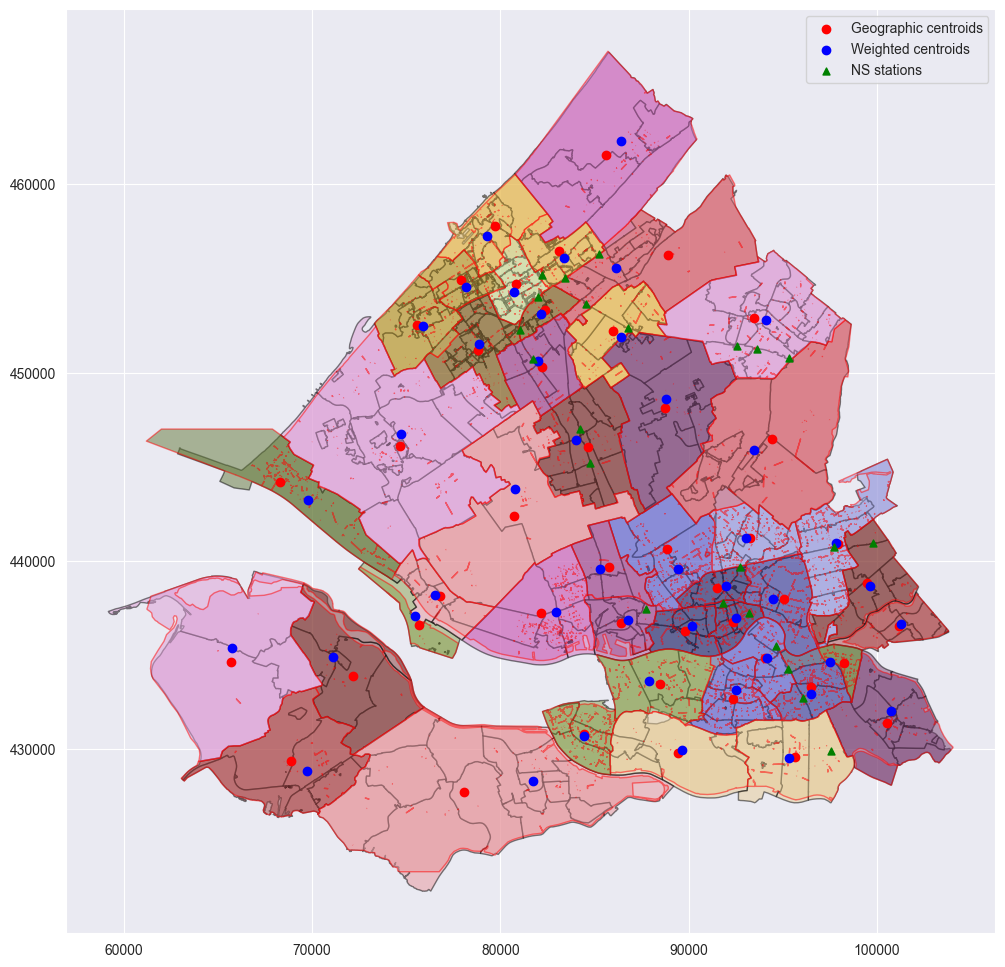

In [12]:
# Plot the population over the map
fig, ax = plt.subplots(figsize=(16, 12))
pop_mrdh.plot(figsize=(16, 12), ax=ax, alpha=0.5, column="65x65 Nummer", cmap="tab20b", edgecolor="black")
mrdh.plot(column=mrdh.index.values, figsize=(16, 12), ax=ax, cmap='tab20b', alpha=0.5, edgecolor='red')
# Add the centroids
mrdh.centroid.plot(ax=ax, color="red")
# Add the weighted centroids
mrdh.weighted_centroid.plot(ax=ax, color="blue")
# Add the NS stations, as a triangle
ns_stations.plot(ax=ax, color="green", marker="^", markersize=25)
# Add a legend
ax.legend(["Geographic centroids", "Weighted centroids", "NS stations"])
# Save the plot
plt.savefig("population_areas_mrdh2.png", dpi=300, bbox_inches="tight")

In [13]:
# Save the population data
pop_mrdh.to_pickle("../data/mrdh_pop.pickle")

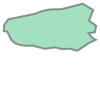

In [14]:
city_polygon

In [15]:
# Select only the 65x65 areas with centroids in the polygon (city_polygon_series
city65 = mrdh[mrdh.centroid.within(city_polygon_series.geometry[0])]
pc65 = pop_mrdh[pop_mrdh['65x65 Nummer'].isin(city65.index)]

# Select the NS stations within the polygon
ns_stations_city = ns_stations[ns_stations.geometry.within(city_polygon_series.geometry[0])]

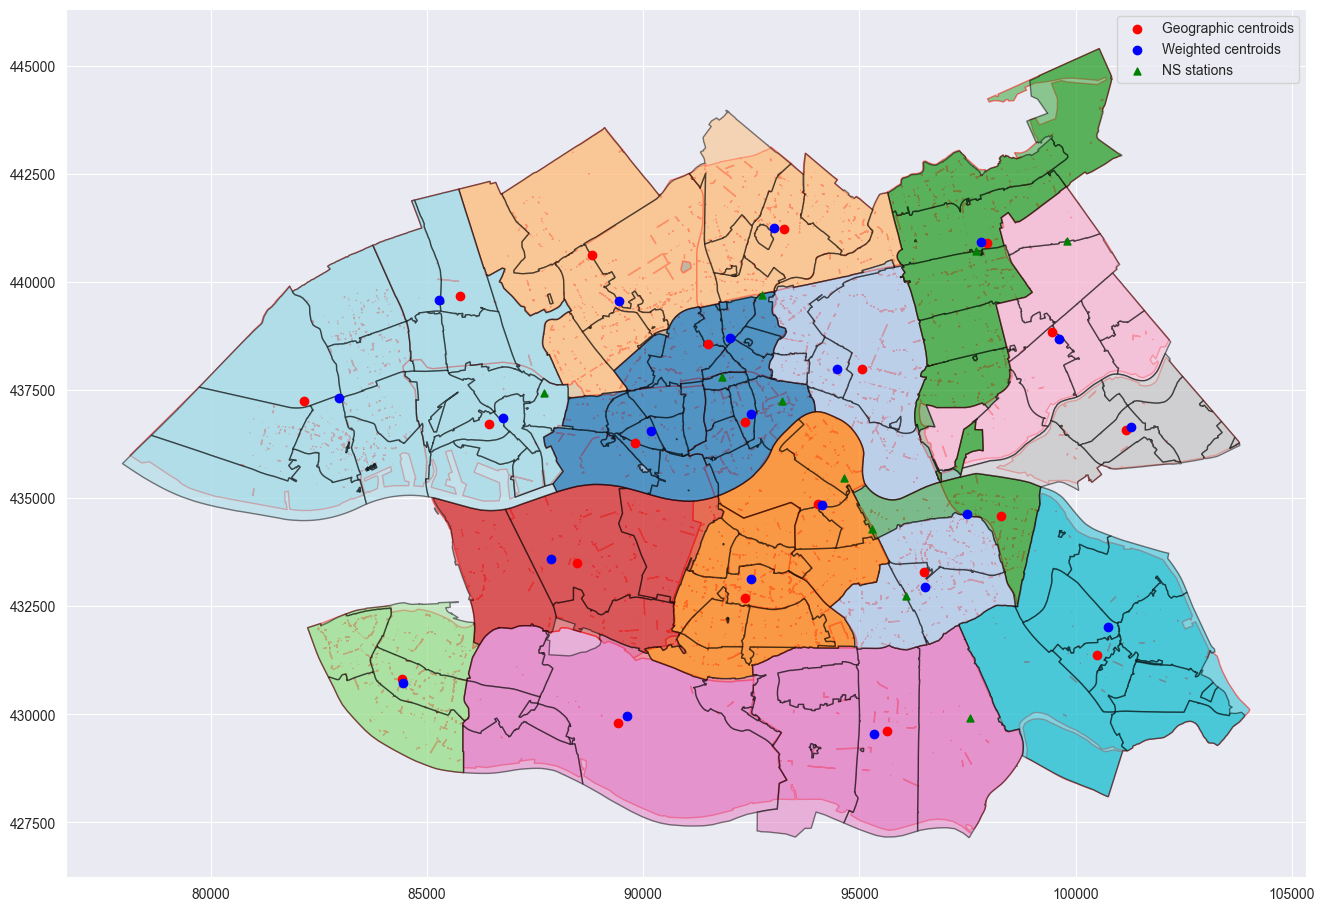

In [16]:
# Plot
fig, ax = plt.subplots(figsize=(16, 12))
city65.plot(column=city65.index.values, ax=ax, cmap='tab20', alpha=0.5, edgecolor='red')
pc65.plot(column="65x65 Nummer", ax=ax, alpha=0.5, cmap="tab20", edgecolor="black")
# Add the centroids
city65.centroid.plot(ax=ax, color="red")
# Add the weighted centroids
city65.weighted_centroid.plot(ax=ax, color="blue")
# Add the NS stations, as a triangle
ns_stations_city.plot(ax=ax, color="green", marker="^", markersize=25)
# Add a legend
ax.legend(["Geographic centroids", "Weighted centroids", "NS stations"])

# Save the plot
plt.savefig("rotterdam_65_grid_centroids.png", dpi=300, bbox_inches="tight")

### Google maps API

In [17]:
# time: 2024-07-02 08:00:00
time = datetime(2024, 7, 2, 8, 0, 0)
print(time)

2024-07-02 08:00:00


In [18]:
# Select stedelijkheid 5 or higher
data_sel = city65.copy()

# Convert to EPSG:4326
data_sel = data_sel.to_crs(epsg=4326)
print("Destination CRS:", data_sel.crs)

# Convert weighted centroids to epsg:4326
data_sel["weighted_centroid"] = data_sel["weighted_centroid"].set_crs(epsg=28992).to_crs(epsg=4326)

Destination CRS: EPSG:4326


In [19]:
# Get API key from /secrets/gmaps_api_key.txt
with open("../secrets/gmap_api_key.txt") as f:
    api_key = f.readline()

In [20]:
run_google_maps = False
if run_google_maps:
    
    gmaps = googlemaps.Client(key=api_key)
    
    # Extract centroids and convert them to a suitable format for the Google Maps API
    centroids = data_sel["weighted_centroid"]
    locations = [(centroid.y, centroid.x) for centroid in centroids]
    print(f"{len(locations)} locations: {locations}")

    # Initialize dictionaries to hold the travel info
    travel_time_pc4 = {}
    travel_distance_pc4 = {}

    # Make 21 requests, each with 21 origins and 21 destinations
    for i in range(len(locations)):
        origin = [locations[i]]
        destinations = locations

        result = gmaps.distance_matrix(
            origins=origin,
            destinations=destinations,
            mode="transit",
            departure_time=time,
        )
        
        # Extract distances and populate the corresponding row in the distance matrix
        for j in range(len(destinations)):
            if i != j:
                element = result["rows"][0]["elements"][j]
                origin_pc4 = data_sel["65x65 Naam"].iloc[i]
                destination_pc4 = data_sel["65x65 Naam"].iloc[j]
                key = (origin_pc4, destination_pc4)
                
                if element["status"] == "OK":
                    distance_meters = element["distance"]["value"]
                    duration_seconds = element["duration"]["value"]
                    
                    # Update the travel info dictionaries
                    travel_distance_pc4[key] = distance_meters
                    travel_time_pc4[key] = duration_seconds
                else:
                    print(f"Error for {key}: {element['status']}")
    # Save as pickle
    with open("travel_time_distance_google.pkl", "wb") as f:
        pickle.dump((travel_time_pc4, travel_distance_pc4), f)

else:
    print(f"Skipping Google Maps API, loading from file.")
    with open("travel_time_distance_google.pkl", "rb") as f:
        travel_time_pc4, travel_distance_pc4 = pickle.load(f)

Skipping Google Maps API, loading from file.


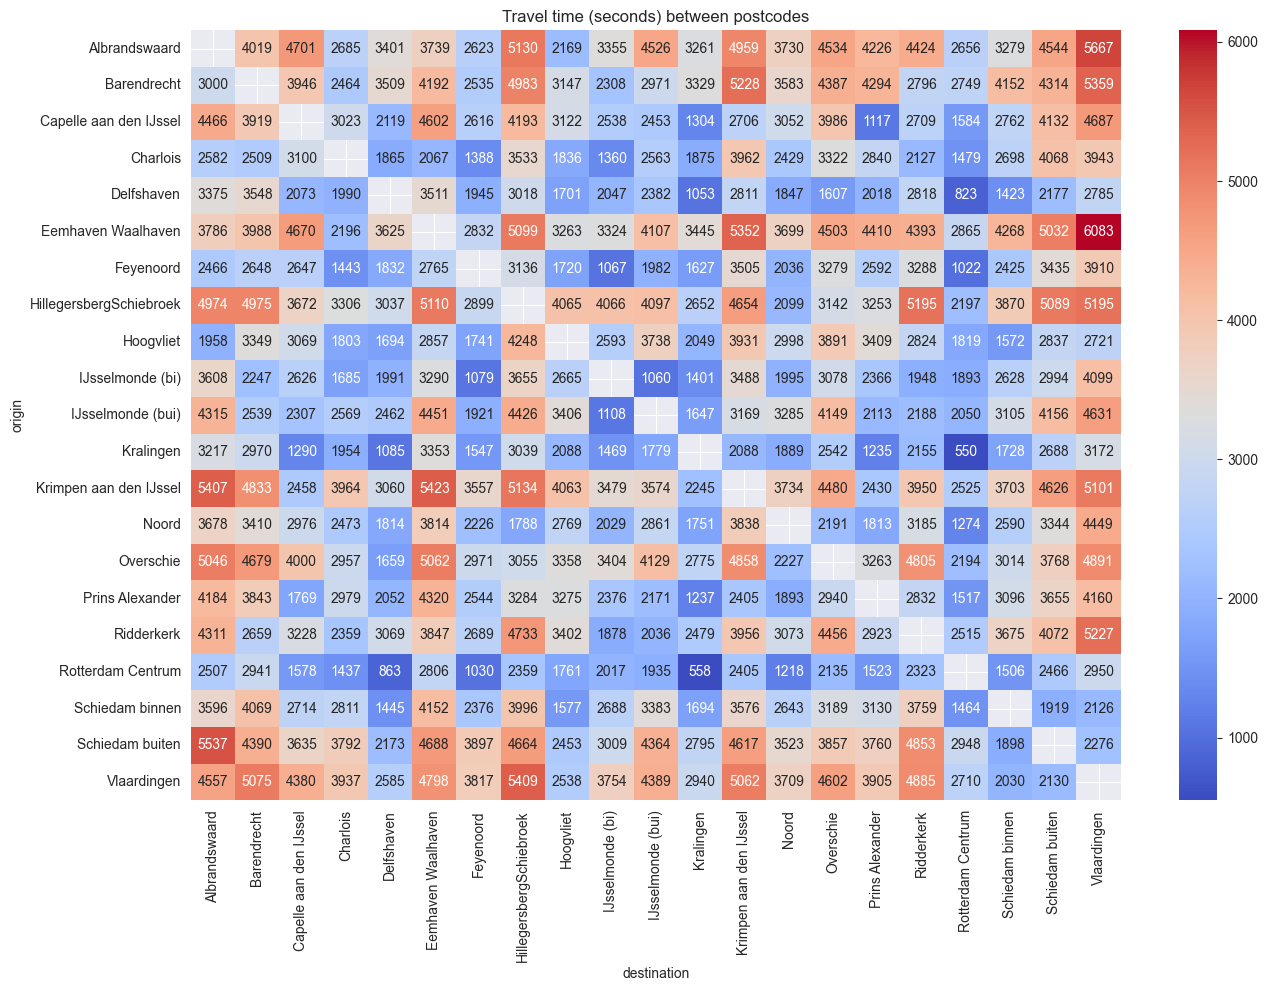

In [21]:
# Make a heatplot of the travel time matrix. First make a dataframe.
travel_time_df = pd.DataFrame(
    travel_time_pc4.values(), index=pd.MultiIndex.from_tuples(travel_time_pc4.keys())
).reset_index()
travel_time_df.columns = ["origin", "destination", "travel_time"]

# Heatmap with seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(travel_time_df.pivot(index="origin", columns="destination", values="travel_time"), annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Travel time (seconds) between postcodes")
# Save the plot
plt.savefig("travel_time_heatmap.png", dpi=300, bbox_inches="tight")

In [22]:
# Convert the data to epsg:28992
data = data_sel.to_crs(epsg=28992)

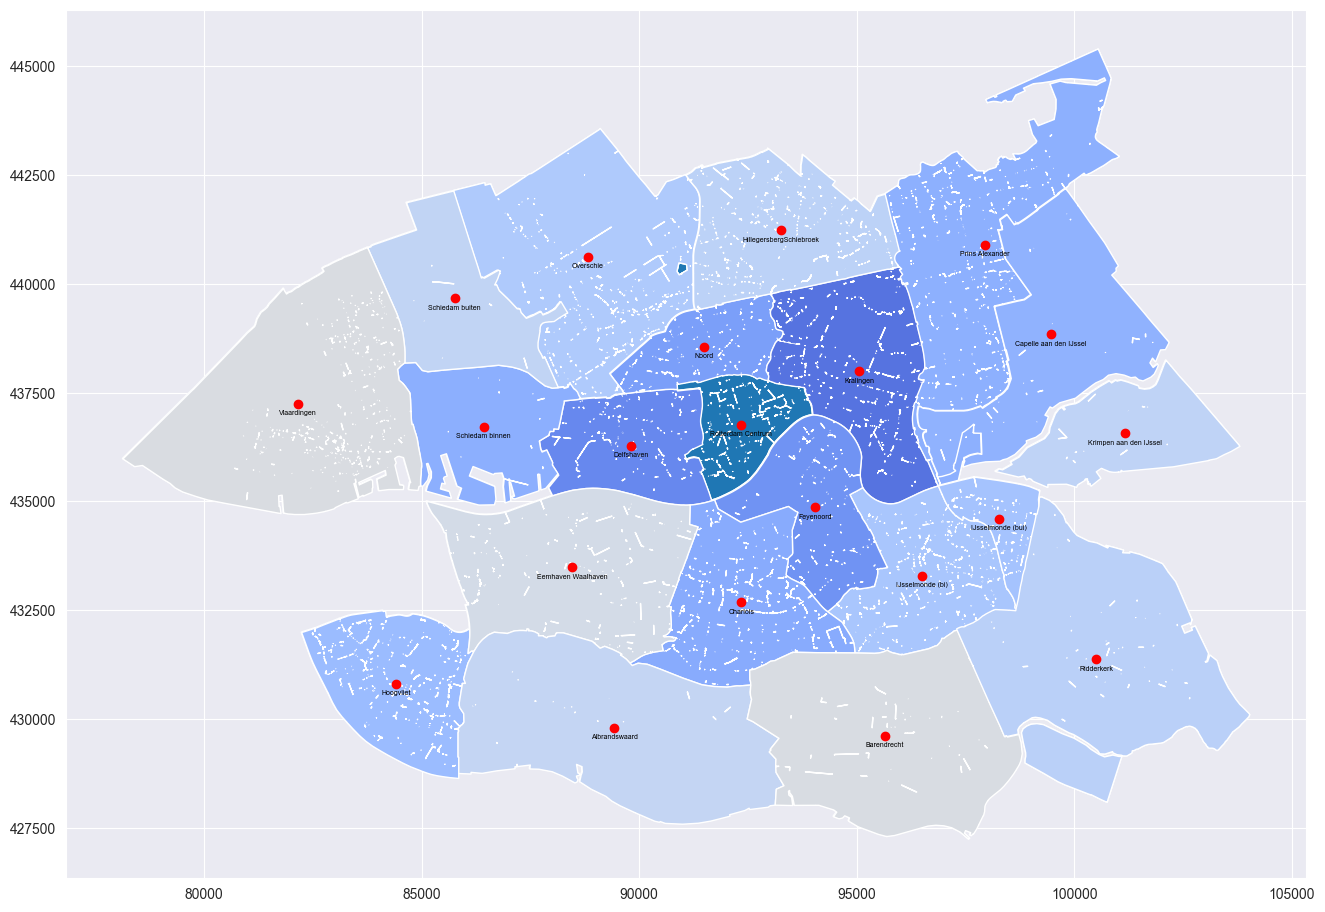

In [23]:
# Plot a map with the travel time from Rotterdam Centrum to all other areas. Green means short travel time, red means long travel time
fig, ax = plt.subplots(figsize=(16, 12))
data.plot(column="GEBIEDEN", figsize=(16, 12), ax=ax)
# Add the name labels above the centroids
for x, y, label in zip(data.centroid.x, data.centroid.y-250, data["65x65 Naam"]):
    ax.text(x, y, label, color="black", fontsize=5, ha="center")
# Add the travel time from Rotterdam Centrum
for idx, row in data.iterrows():
    destination = row["65x65 Naam"]
    if destination == "Rotterdam Centrum":
        continue
    travel_time = travel_time_pc4[("Rotterdam Centrum", destination)]
    if travel_time is not None:
        color = sns.color_palette("coolwarm", as_cmap=True)(travel_time / travel_time_df["travel_time"].max())
        data[data["65x65 Naam"] == destination].plot(color=color, ax=ax)
# Add the centroids
data.centroid.plot(ax=ax, color="red")
# Save the plot
plt.savefig("travel_time_rotterdam_centrum.png", dpi=300, bbox_inches="tight")